Connexion réussie à SQL Server


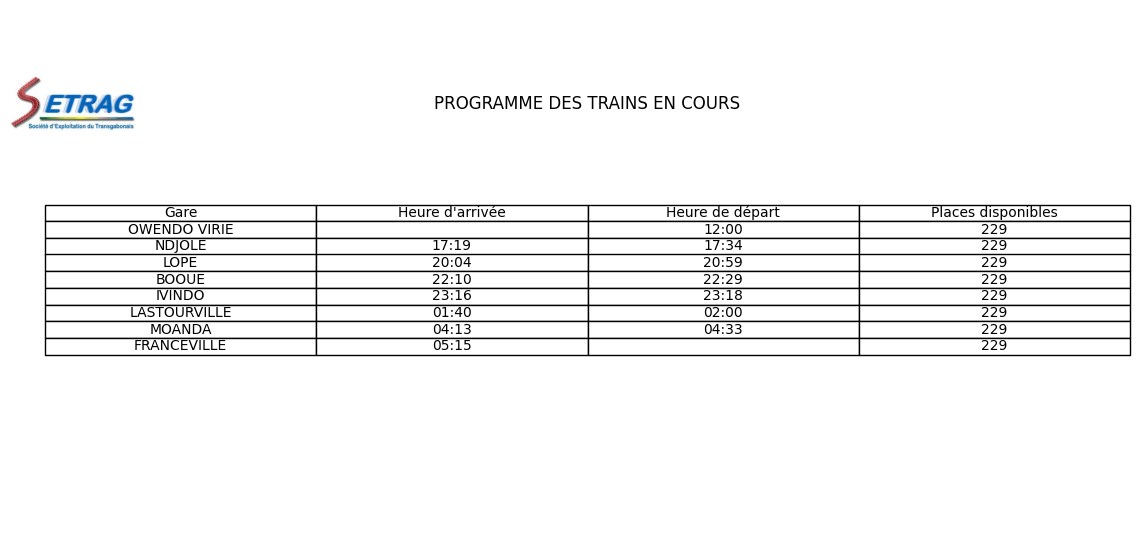

In [8]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sshtunnel import SSHTunnelForwarder
import pyodbc

# Define your SSH and MySQL credentials
ssh_host = '10.120.21.103'
ssh_port = 22
ssh_user = 'setrag'
ssh_password = 'Wabjtam,123'

mysql_host = '192.168.21.110'
mysql_port = 3306
mysql_user = 'galera'
mysql_password = 'galera'
mysql_db = 'setrag_beta1'

server = 'mavagha-dv1-sqls.database.windows.net'
database = 'mavaghasqld'
username = 'SicomAdminUser'
password = 'MUdNRsrTl6eF5KjzlVcr'
driver = '{ODBC Driver 18 for SQL Server}'

try:
    conn = pyodbc.connect(
        f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
    )
    print("Connexion réussie à SQL Server")
    
    cursor = conn.cursor()
    cursor.execute(
            """SELECT 
                  [NUMERO_TRAIN]
                  ,[CATEGORIE_TRAIN]
                  ,FORMAT(REAL_DT_FROM, 'yyyy-MM-dd') AS "DATE DE DEPART"
                  ,FORMAT([REAL_DT_TO], 'yyyy-MM-dd') AS "DATE D'ARRIVEE"
            	  ,FORMAT([REAL_DT_FROM], 'HH:mm') AS "HEURE DE DEPART REEL"
            	  ,FORMAT([REAL_DT_TO], 'HH:mm') AS "HEURE D'ARRIVEE REEL"
                  ,[REAL_TEMPS_PARC_H_EN_CANTON]
                  ,[REAL_TEMPS_PARC_H_EN_GARE]
            FROM [tcs].[SP_ERAMET_VTRAIN_MINI]
            WHERE CATEGORIE_TRAIN IN ('Voyageurs express', 'Voyageurs omnibus')
            AND FORMAT(REAL_DT_TO, 'yyyy-MM-dd') BETWEEN '2024-12-01' AND '2024-12-31'
            """
        )
    trains_inforail = cursor.fetchall()
    columns = [column[0] for column in cursor.description]

    cursor.close()
    conn.close()
except Exception as e:
    print(f"Erreur de connexion : {e}")

# Charger l'image
image_path = 'setraglogo.jpg'
img = mpimg.imread(image_path)

# Establish the SSH tunnel
with SSHTunnelForwarder(
    (ssh_host, ssh_port),
    ssh_username=ssh_user,
    ssh_password=ssh_password,
    remote_bind_address=(mysql_host, mysql_port)
) as tunnel:
    # Connect to the MySQL database
    connection = pymysql.connect(
        host='127.0.0.1',
        user=mysql_user,
        password=mysql_password,
        db=mysql_db,
        port=tunnel.local_bind_port
    )

    # Execute a query
    with connection.cursor() as cursor:
        #Recovery of available seats on all trains for the current month
        cursor.execute("""
                            SELECT t.number AS "N° TRAIN",
                            	   tp.label AS "TYPE DE TRAIN",
                                   DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                                   DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%H:%i") AS "HEURE DE DEPART",
                                   IF(wdr.departure_station = 1, "OWENDO VIRIE", "FRANCEVILLE") AS "GARE DE DEPART",
                                   IF(wdr.arrival_station = 23, "FRANCEVILLE", "OWENDO VIRIE") AS "GARE D'ARRIVEE",
                            	   count(sbr.seat_occupation_flag) AS "PLACES DISPONIBLES"
                            FROM train AS t
                            INNER JOIN seat_booking_record AS sbr
                            ON sbr.train_id = t.id
                            INNER JOIN seat AS s
                            ON s.id = sbr.seat_id
                            INNER JOIN car AS c
                            ON c.id = s.car_id
                            INNER JOIN train_type tp
                            ON t.train_type_id = tp.id
                            INNER JOIN week_day_route  wdr
                            ON wdr.id = t.week_day_route_id
                            WHERE
                            (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP(DATE_FORMAT(CURDATE(), '%Y-%m-01 00:00:00')) AND UNIX_TIMESTAMP(DATE_FORMAT(LAST_DAY(CURDATE()), '%Y-%m-%d 23:59:59'))
                            AND sbr.seat_occupation_flag = 0 AND tp.label IN ('EXPRESS', 'OMNIBUS')
                            GROUP BY DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y"), t.number
                        """)
        trains_places_dispo = cursor.fetchall()
        field_names = [i[0] for i in cursor.description]
        """print(field_names)
        for result in trains_places_dispo:
            print(result)"""

        # Requête d'itineraire des trains en cours
        query_itineraire_train = """
                                        SELECT 
                                    		wdr.train_number,
                                            ts.name,
                                            tt.label,
                                            DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                                    		DATE_FORMAT(FROM_UNIXTIME(rs.arrival_time/1000), "%H:%i") AS "HEURE D'ARRIVEE",
                                    		DATE_FORMAT(FROM_UNIXTIME(rs.departure_time/1000), "%H:%i") AS "HEURE DE DEPART",
                                            DATE_FORMAT(FROM_UNIXTIME(rs.stop_duration/1000), "%H:%i") AS "HEURE DE D'ARRET"
                                        FROM route_station rs
                                        INNER JOIN train_station ts
                                        ON ts.id = rs.train_station_id
                                        INNER JOIN week_day_route wdr
                                        ON wdr.id = rs.week_day_route_id
                                        INNER JOIN train_type tt
                                        ON tt.id = wdr.train_type_id
                                        INNER JOIN train t
                                        ON t.week_day_route_id = wdr.id
                                        WHERE
                                        #(t.planned_date/1000) BETWEEN UNIX_TIMESTAMP(NOW()) AND UNIX_TIMESTAMP(DATE_ADD(NOW(), INTERVAL 1 DAY))
                                        (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP('2024-12-14 00:00:00') AND UNIX_TIMESTAMP('2024-12-14 23:59:59')
                                        AND tt.label IN ('EXPRESS', 'OMNIBUS')
                                """
        cursor.execute(query_itineraire_train)
        trains_itineraire_details = cursor.fetchall()
    
        data_express = []
        data_omnibus = []
        
        for details in trains_itineraire_details:
            for train in trains_places_dispo:
                if train[0] == details[0] and details[3] == train[2] and details[2] == "EXPRESS":
                    #print(details[1]," ",details[4], " ", details[5], " ",train[6])
                    donnees = (details[1], details[4],details[5],train[6])
                    data_express.append(donnees)
                if train[0] == details[0] and details[3] == train[2] and details[2] == "OMNIBUS":
                    donnees = (details[1], details[4],details[5],train[6])
                    data_omnibus.append(donnees)
                    
        df_express = pd.DataFrame(data_express, columns=["Gare", "Heure d'arrivée", "Heure de départ", "Places disponibles"])
        #df_omnibus = pd.DataFrame(data_omnibus, columns=["Gare", "Heure d'arrivée", "Heure de départ", "Places disponibles"])
        styled_df = df_express.style.set_table_styles(
            [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
        )
        styled_df
        #print(df_express)
        #print(df_omnibus)
        # Plot the DataFrame as a table
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.axis('tight')
        ax.axis('off')

        ax.set_title("PROGRAMME DES TRAINS EN COURS", y=0.8)
        table = ax.table(cellText=df_express.values, colLabels=df_express.columns, cellLoc='center', loc='center')
        #ax.table(cellText=df_omnibus.values, colLabels=df_omnibus.columns, cellLoc='center', loc='center')

        # Ajouter un nouvel axe pour le logo
        logo_ax = fig.add_axes([0.1, 0.7, 0.09, 0.085], anchor='NE', zorder=-1)
        logo_ax.imshow(img)
        logo_ax.axis('off')  # Masquer les axes du logo
        
        # Save the table as a JPEG image
        plt.savefig('express.jpg', format='jpeg')
    # Close the connection
    connection.close()